In [1]:
import warnings
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

import xgboost as xgb
import optuna


warnings.simplefilter('ignore', FutureWarning)

In [2]:
!pip install xgboost
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [3]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

In [4]:
train_df = pd.read_csv('/kaggle/input/data-all/train_all/train_all.csv')
test_df = pd.read_csv('/kaggle/input/data-all/train_all/test_all.csv')

In [5]:
X_train = train_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_train = train_df['AWS']

X_test = test_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_test = test_df['AWS']

## Chuẩn hóa

In [6]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Chọn feature

In [7]:
top_features = ['B14B', 'I2B', 'TCLW', 'R500', 'R850', 'CAPE', 'U850', 'B10B', 'PEV', 'SLOR', 'R250', 'KX', 'V250', 'U250', 'TCWV']

## Hàm bổ trợ

In [8]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()

scale_pos_weight= neg / pos
print(f"scale_pos_weight= {scale_pos_weight:.3f}")

scale_pos_weight= 11.078


In [9]:
def print_scores(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    print(classification_report(y_true, y_pred))

In [10]:
def train_and_evaluate_xgb(X_train, y_train, X_test, y_test, scale_pos_weight=None, top_features=None):
    model_xgb = xgb.XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight)

    if top_features is not None:
        X_train = X_train[top_features]
        X_test = X_test[top_features]
    
    model_xgb.fit(X_train, y_train)
    y_pred = model_xgb.predict(X_test)
    print_scores(y_test, y_pred)

In [11]:
def objective(trial, X_train_scaled, y_train, X_test_scaled, y_test, 
              use_smote=False, use_smoteenn=False, 
              scale_pos_weight=None, top_features=None):
    # Tối ưu hóa các tham số
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'scale_pos_weight': scale_pos_weight if not (use_smote or use_smoteenn) else None,
        'random_state': 42,
        'verbosity': 0,
        'n_jobs': -1,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }

     # Sử dụng top_features để chọn các đặc trưng quan trọng
    if top_features is not None:
        X_train_scaled = X_train_scaled[top_features]
        X_test_scaled = X_test_scaled[top_features]
        
    # Khởi tạo mô hình với tham số tối ưu
    model = xgb.XGBClassifier(**param)
    model.fit(X_train_scaled, y_train)
    
    # Dự đoán và tối ưu hóa threshold
    y_probs = model.predict_proba(X_test_scaled)[:, 1]
    best_thresh = trial.suggest_float('threshold', 0.1, 0.9, step=0.05)
    y_pred = (y_probs >= best_thresh).astype(int)

    # Đánh giá mô hình với F1 score
    return f1_score(y_test, y_pred, pos_label=1)

In [12]:
def optimize_and_train(X_train_scaled, y_train, X_test_scaled, y_test,
                       use_smote=False, use_smoteenn=False,
                       scale_pos_weight=None, top_features=None,
                       n_trials=50):
    # Tạo study và tối ưu hóa tham số
    study = optuna.create_study(direction='maximize')

    # Thay đổi lambda function để truyền đúng các đối số vào objective
    study.optimize(lambda trial: objective(trial, X_train_scaled, y_train, X_test_scaled, y_test,
                                           use_smote, use_smoteenn, scale_pos_weight, top_features),
                   n_trials=n_trials)

    # In kết quả của trial tốt nhất
    print("Best trial:")
    print(study.best_trial)
    print("Best hyperparameters:")
    for key, value in study.best_trial.params.items():
        print(f"{key}: {value}")

    # Huấn luyện lại với tham số tốt nhất
    best_params = study.best_trial.params
    best_thresh = best_params.pop('threshold')  # Lấy ngưỡng tối ưu từ Optuna

    best_params.update({
        'scale_pos_weight': scale_pos_weight if not (use_smote or use_smoteenn) else None,
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    })
    
    best_model = xgb.XGBClassifier(**best_params)
    best_model.fit(X_train_scaled, y_train)

    # Dự đoán với threshold tối ưu
    y_probs = best_model.predict_proba(X_test_scaled)[:, 1]
    y_pred_thresh = (y_probs >= best_thresh).astype(int)

    print(f"Best threshold: {best_thresh}")
    print_scores(y_test, y_pred_thresh)

# Không SMOTE

## Data

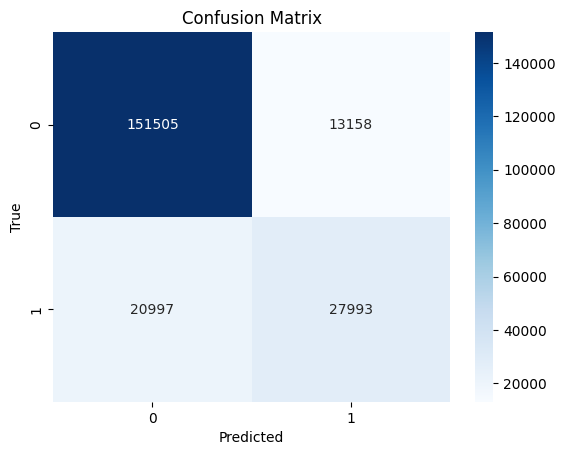

              precision    recall  f1-score   support

           0       0.88      0.92      0.90    164663
           1       0.68      0.57      0.62     48990

    accuracy                           0.84    213653
   macro avg       0.78      0.75      0.76    213653
weighted avg       0.83      0.84      0.84    213653



In [13]:
train_and_evaluate_xgb(X_train_scaled, y_train, X_test_scaled, y_test)

## Data tune

[I 2025-05-05 15:37:46,920] A new study created in memory with name: no-name-6d4866d8-d264-4f48-8834-8cf2790a1a3a
[I 2025-05-05 15:37:57,123] Trial 0 finished with value: 0.6874671238481171 and parameters: {'n_estimators': 175, 'learning_rate': 0.033657139665837055, 'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.8886060055752382, 'colsample_bytree': 0.8254841298411244, 'gamma': 2.1179567978127873, 'threshold': 0.4}. Best is trial 0 with value: 0.6874671238481171.
[I 2025-05-05 15:38:05,112] Trial 1 finished with value: 0.40809719144388384 and parameters: {'n_estimators': 245, 'learning_rate': 0.05637004327618014, 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.9843199441200687, 'colsample_bytree': 0.7766121138102371, 'gamma': 4.0927347918129025, 'threshold': 0.75}. Best is trial 0 with value: 0.6874671238481171.
[I 2025-05-05 15:38:22,487] Trial 2 finished with value: 0.6719662654977957 and parameters: {'n_estimators': 423, 'learning_rate': 0.09138022912837208, 'max_depth'

Best trial:
FrozenTrial(number=42, state=1, values=[0.6889136288810862], datetime_start=datetime.datetime(2025, 5, 5, 15, 46, 8, 734805), datetime_complete=datetime.datetime(2025, 5, 5, 15, 46, 23, 376989), params={'n_estimators': 359, 'learning_rate': 0.05993294864485149, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.7603241354890383, 'colsample_bytree': 0.8485825454834679, 'gamma': 0.6243712470602505, 'threshold': 0.35}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=5.0, log=False, low=0.0

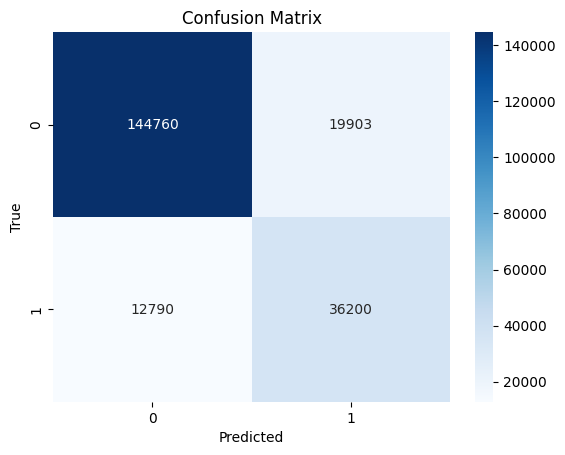

              precision    recall  f1-score   support

           0       0.92      0.88      0.90    164663
           1       0.65      0.74      0.69     48990

    accuracy                           0.85    213653
   macro avg       0.78      0.81      0.79    213653
weighted avg       0.86      0.85      0.85    213653



In [14]:
optimize_and_train(X_train_scaled, y_train, X_test_scaled, y_test)

## Data + feature

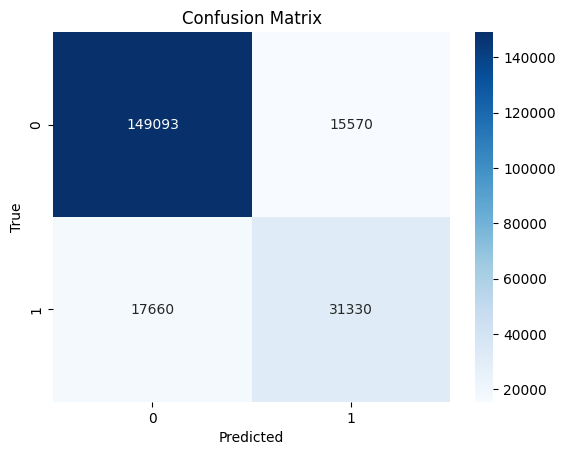

              precision    recall  f1-score   support

           0       0.89      0.91      0.90    164663
           1       0.67      0.64      0.65     48990

    accuracy                           0.84    213653
   macro avg       0.78      0.77      0.78    213653
weighted avg       0.84      0.84      0.84    213653



In [15]:
train_and_evaluate_xgb(X_train_scaled, y_train, X_test_scaled, y_test, top_features=top_features)

## Data + Feature + Tune

[I 2025-05-05 15:48:27,699] A new study created in memory with name: no-name-d56ab38d-553b-4604-a8d5-621ec342a8b5
[I 2025-05-05 15:48:33,036] Trial 0 finished with value: 0.5741819284639998 and parameters: {'n_estimators': 305, 'learning_rate': 0.23714294499163394, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.9241699163562406, 'colsample_bytree': 0.9968174067592489, 'gamma': 2.2494701795587577, 'threshold': 0.1}. Best is trial 0 with value: 0.5741819284639998.
[I 2025-05-05 15:48:37,918] Trial 1 finished with value: 0.6420329190673459 and parameters: {'n_estimators': 172, 'learning_rate': 0.2902759393459883, 'max_depth': 7, 'min_child_weight': 7, 'subsample': 0.5706658320503659, 'colsample_bytree': 0.9833847862742601, 'gamma': 2.5951424062987156, 'threshold': 0.25}. Best is trial 1 with value: 0.6420329190673459.
[I 2025-05-05 15:48:42,520] Trial 2 finished with value: 0.66201431085874 and parameters: {'n_estimators': 321, 'learning_rate': 0.2441006918599702, 'max_depth': 3, '

Best trial:
FrozenTrial(number=39, state=1, values=[0.6723498888065234], datetime_start=datetime.datetime(2025, 5, 5, 15, 52, 33, 182004), datetime_complete=datetime.datetime(2025, 5, 5, 15, 52, 44, 91823), params={'n_estimators': 385, 'learning_rate': 0.17495850380005698, 'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.7192697005295479, 'colsample_bytree': 0.8646293759700238, 'gamma': 2.0711098237083907, 'threshold': 0.45000000000000007}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=5.0, log

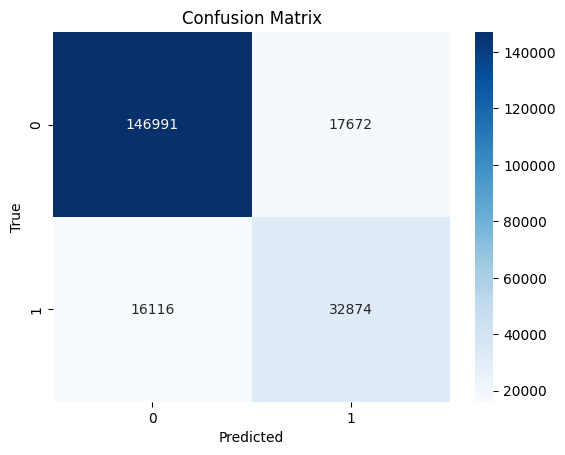

              precision    recall  f1-score   support

           0       0.90      0.89      0.90    164663
           1       0.65      0.67      0.66     48990

    accuracy                           0.84    213653
   macro avg       0.78      0.78      0.78    213653
weighted avg       0.84      0.84      0.84    213653



In [16]:
optimize_and_train(X_train_scaled, y_train, X_test_scaled, y_test, top_features=top_features)

## Data + scale_pos_weight

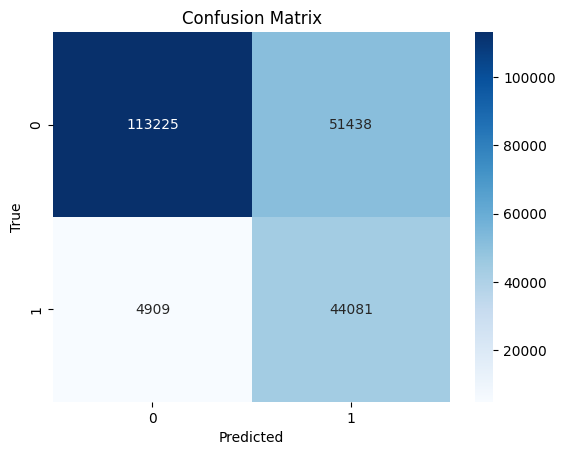

              precision    recall  f1-score   support

           0       0.96      0.69      0.80    164663
           1       0.46      0.90      0.61     48990

    accuracy                           0.74    213653
   macro avg       0.71      0.79      0.71    213653
weighted avg       0.84      0.74      0.76    213653



In [17]:
train_and_evaluate_xgb(X_train_scaled, y_train, X_test_scaled, y_test, scale_pos_weight=scale_pos_weight)

## Data + scale_pos_weight + Tune

[I 2025-05-05 15:54:16,128] A new study created in memory with name: no-name-fdb4ee5e-ac5a-4301-93de-3832b989ee64
[I 2025-05-05 15:54:34,043] Trial 0 finished with value: 0.6624976741552128 and parameters: {'n_estimators': 239, 'learning_rate': 0.027196395373300042, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.5595260582470594, 'colsample_bytree': 0.8495142794901629, 'gamma': 2.5168982944518525, 'threshold': 0.65}. Best is trial 0 with value: 0.6624976741552128.
[I 2025-05-05 15:54:40,004] Trial 1 finished with value: 0.5538639159868686 and parameters: {'n_estimators': 204, 'learning_rate': 0.13362609957736898, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.5362087668828335, 'colsample_bytree': 0.6977801292632171, 'gamma': 2.0717878470692646, 'threshold': 0.35}. Best is trial 0 with value: 0.6624976741552128.
[I 2025-05-05 15:54:43,260] Trial 2 finished with value: 0.6376938771033059 and parameters: {'n_estimators': 103, 'learning_rate': 0.14494466794741323, 'max_depth

Best trial:
FrozenTrial(number=43, state=1, values=[0.6792446481894269], datetime_start=datetime.datetime(2025, 5, 5, 16, 5, 31, 188068), datetime_complete=datetime.datetime(2025, 5, 5, 16, 5, 37, 671934), params={'n_estimators': 187, 'learning_rate': 0.1310119089669971, 'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.7467001806561999, 'colsample_bytree': 0.6641385111068606, 'gamma': 1.9527430397369132, 'threshold': 0.75}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=5.0, log=False, low=0.0, 

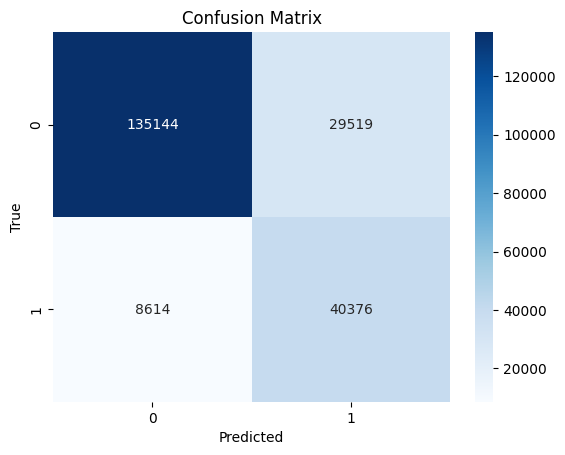

              precision    recall  f1-score   support

           0       0.94      0.82      0.88    164663
           1       0.58      0.82      0.68     48990

    accuracy                           0.82    213653
   macro avg       0.76      0.82      0.78    213653
weighted avg       0.86      0.82      0.83    213653



In [18]:
optimize_and_train(X_train_scaled, y_train, X_test_scaled, y_test,scale_pos_weight=scale_pos_weight)

## Data + scale_pos_weight + feature 

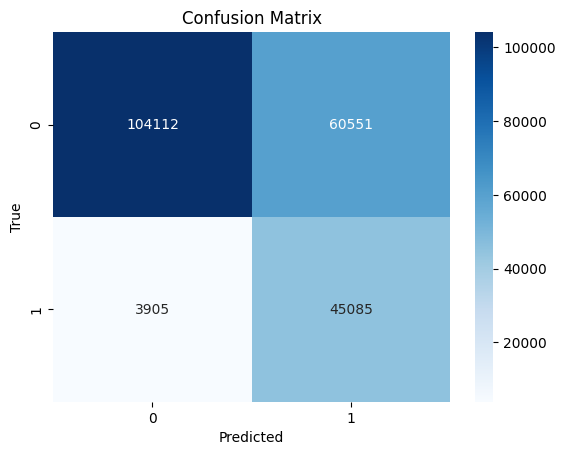

              precision    recall  f1-score   support

           0       0.96      0.63      0.76    164663
           1       0.43      0.92      0.58     48990

    accuracy                           0.70    213653
   macro avg       0.70      0.78      0.67    213653
weighted avg       0.84      0.70      0.72    213653



In [19]:
train_and_evaluate_xgb(X_train_scaled, y_train, X_test_scaled, y_test, scale_pos_weight=scale_pos_weight, top_features=top_features)

## Data + scale_pos_weight + feature + tune

[I 2025-05-05 16:06:22,100] A new study created in memory with name: no-name-aa98649a-38f9-4480-9f10-554ed221896a
[I 2025-05-05 16:06:34,754] Trial 0 finished with value: 0.6686103400762825 and parameters: {'n_estimators': 353, 'learning_rate': 0.07802585039579185, 'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.9279632602680024, 'colsample_bytree': 0.6109262680784469, 'gamma': 4.759993076078247, 'threshold': 0.8}. Best is trial 0 with value: 0.6686103400762825.
[I 2025-05-05 16:06:40,142] Trial 1 finished with value: 0.5663395479851138 and parameters: {'n_estimators': 262, 'learning_rate': 0.06147179558372539, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.5973790146645095, 'colsample_bytree': 0.9793578042117201, 'gamma': 2.4807381243759767, 'threshold': 0.5}. Best is trial 0 with value: 0.6686103400762825.
[I 2025-05-05 16:06:43,650] Trial 2 finished with value: 0.653435502307269 and parameters: {'n_estimators': 202, 'learning_rate': 0.2925178378000065, 'max_depth': 4,

Best trial:
FrozenTrial(number=30, state=1, values=[0.6800007435358848], datetime_start=datetime.datetime(2025, 5, 5, 16, 10, 51, 300205), datetime_complete=datetime.datetime(2025, 5, 5, 16, 11, 0, 271214), params={'n_estimators': 466, 'learning_rate': 0.09905443130585309, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.5609711475984863, 'colsample_bytree': 0.7216099924550554, 'gamma': 1.4078318081612393, 'threshold': 0.85}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=5.0, log=False, low=0.0

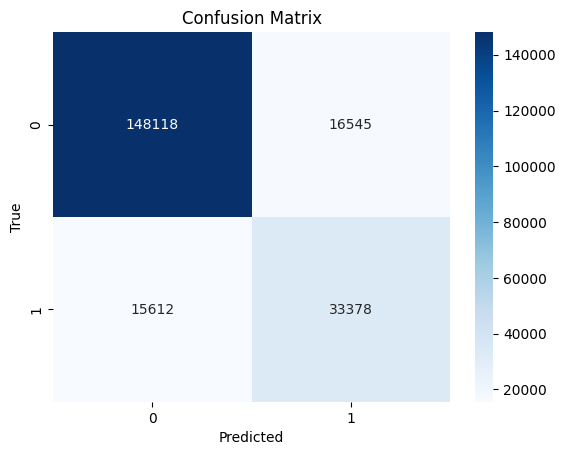

              precision    recall  f1-score   support

           0       0.90      0.90      0.90    164663
           1       0.67      0.68      0.67     48990

    accuracy                           0.85    213653
   macro avg       0.79      0.79      0.79    213653
weighted avg       0.85      0.85      0.85    213653



In [20]:
optimize_and_train(X_train_scaled, y_train, X_test_scaled, y_test,scale_pos_weight=scale_pos_weight, top_features = top_features)

# SMOTE

In [21]:
sm = SMOTE()

X_sm, y_sm = sm.fit_resample(X_train, y_train)
X_sm.shape, y_sm.shape

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_sm)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Data SMOTE 

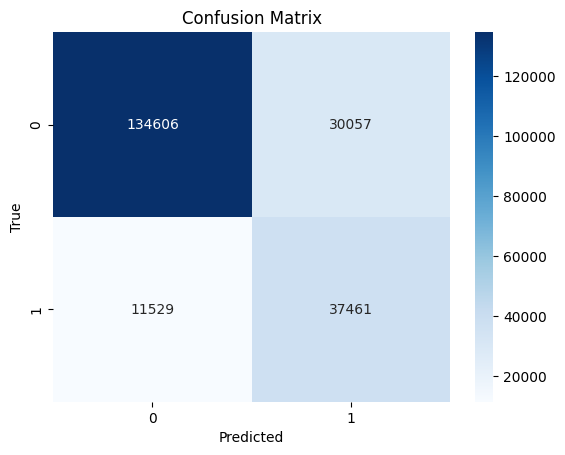

              precision    recall  f1-score   support

           0       0.92      0.82      0.87    164663
           1       0.55      0.76      0.64     48990

    accuracy                           0.81    213653
   macro avg       0.74      0.79      0.75    213653
weighted avg       0.84      0.81      0.82    213653



In [22]:
train_and_evaluate_xgb(X_train_scaled, y_sm, X_test_scaled, y_test)

## Data SMOTE + Tune

[I 2025-05-05 16:14:09,656] A new study created in memory with name: no-name-2745f3ee-87ae-49cf-b198-dfff204e861f
[I 2025-05-05 16:14:32,381] Trial 0 finished with value: 0.6253195063170963 and parameters: {'n_estimators': 252, 'learning_rate': 0.23655050597838043, 'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.6778672570163264, 'colsample_bytree': 0.8336453377333861, 'gamma': 2.2798869078741846, 'threshold': 0.35}. Best is trial 0 with value: 0.6253195063170963.
[I 2025-05-05 16:14:42,905] Trial 1 finished with value: 0.6473922704130728 and parameters: {'n_estimators': 218, 'learning_rate': 0.22985206639586417, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.5608169740032982, 'colsample_bytree': 0.6295511004948848, 'gamma': 3.2583656765081015, 'threshold': 0.55}. Best is trial 1 with value: 0.6473922704130728.
[I 2025-05-05 16:15:00,841] Trial 2 finished with value: 0.6201641183401894 and parameters: {'n_estimators': 339, 'learning_rate': 0.24840637408406097, 'max_depth'

Best trial:
FrozenTrial(number=46, state=1, values=[0.6588542148393423], datetime_start=datetime.datetime(2025, 5, 5, 16, 31, 14, 319629), datetime_complete=datetime.datetime(2025, 5, 5, 16, 31, 35, 936341), params={'n_estimators': 389, 'learning_rate': 0.059846199423270255, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.6796279878485483, 'colsample_bytree': 0.832314937650082, 'gamma': 2.7005973051569514, 'threshold': 0.6}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=5.0, log=False, low=0.0

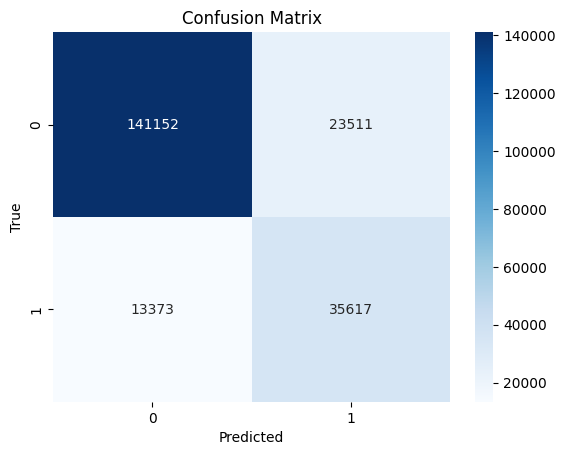

              precision    recall  f1-score   support

           0       0.91      0.86      0.88    164663
           1       0.60      0.73      0.66     48990

    accuracy                           0.83    213653
   macro avg       0.76      0.79      0.77    213653
weighted avg       0.84      0.83      0.83    213653



In [23]:
optimize_and_train(X_train_scaled, y_sm, X_test_scaled, y_test, use_smote=True)

## Data SMOTE + Feature

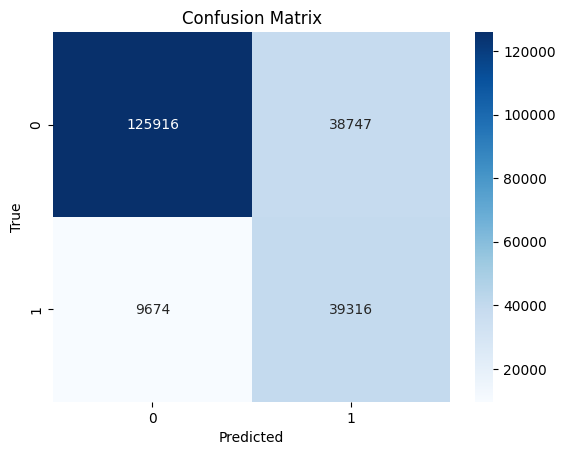

              precision    recall  f1-score   support

           0       0.93      0.76      0.84    164663
           1       0.50      0.80      0.62     48990

    accuracy                           0.77    213653
   macro avg       0.72      0.78      0.73    213653
weighted avg       0.83      0.77      0.79    213653



In [24]:
train_and_evaluate_xgb(X_train_scaled, y_sm, X_test_scaled, y_test, top_features = top_features)

## Data SMOTE + Feature + Tune

[I 2025-05-05 16:33:13,462] A new study created in memory with name: no-name-f7c729ba-00ec-4ab6-bece-69b8c97dcec5
[I 2025-05-05 16:33:29,491] Trial 0 finished with value: 0.5541405642690567 and parameters: {'n_estimators': 288, 'learning_rate': 0.169806139711433, 'max_depth': 9, 'min_child_weight': 8, 'subsample': 0.8767584217937747, 'colsample_bytree': 0.9883841214280213, 'gamma': 2.664837571695875, 'threshold': 0.75}. Best is trial 0 with value: 0.5541405642690567.
[I 2025-05-05 16:33:38,283] Trial 1 finished with value: 0.593412012448271 and parameters: {'n_estimators': 266, 'learning_rate': 0.2598234090375351, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.6161482138672196, 'colsample_bytree': 0.517170159654725, 'gamma': 1.8393258789777382, 'threshold': 0.30000000000000004}. Best is trial 1 with value: 0.593412012448271.
[I 2025-05-05 16:33:50,138] Trial 2 finished with value: 0.540612116270867 and parameters: {'n_estimators': 165, 'learning_rate': 0.140854023790353, 'max_de

Best trial:
FrozenTrial(number=41, state=1, values=[0.6486834481426641], datetime_start=datetime.datetime(2025, 5, 5, 16, 43, 30, 735524), datetime_complete=datetime.datetime(2025, 5, 5, 16, 43, 47, 280388), params={'n_estimators': 416, 'learning_rate': 0.04595935498845618, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.6783201124452591, 'colsample_bytree': 0.8673468696082436, 'gamma': 4.726070607107612, 'threshold': 0.7000000000000001}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=5.0, log=

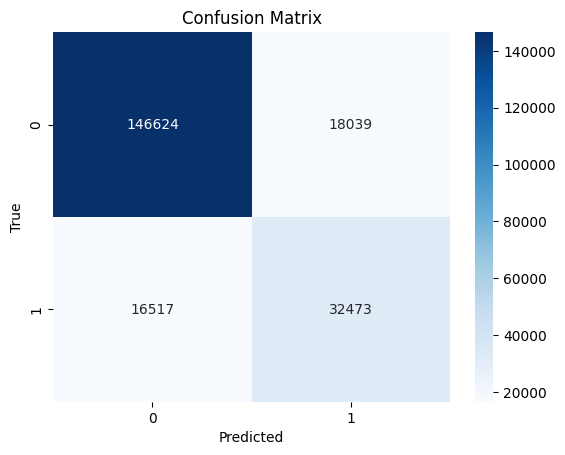

              precision    recall  f1-score   support

           0       0.90      0.89      0.89    164663
           1       0.64      0.66      0.65     48990

    accuracy                           0.84    213653
   macro avg       0.77      0.78      0.77    213653
weighted avg       0.84      0.84      0.84    213653



In [25]:
optimize_and_train(X_train_scaled, y_sm, X_test_scaled, y_test, top_features=top_features, use_smote = True)

# SMOTE ENN

In [26]:
smenn = SMOTEENN()

X_smenn, y_smenn = smenn.fit_resample(X_train, y_train)
X_smenn.shape, y_sm.shape

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_smenn)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Data SMOTE ENN 

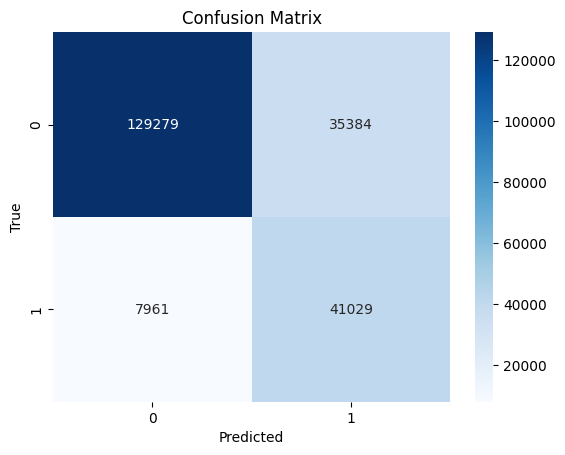

              precision    recall  f1-score   support

           0       0.94      0.79      0.86    164663
           1       0.54      0.84      0.65     48990

    accuracy                           0.80    213653
   macro avg       0.74      0.81      0.76    213653
weighted avg       0.85      0.80      0.81    213653



In [27]:
train_and_evaluate_xgb(X_train_scaled, y_smenn, X_test_scaled, y_test)

## Data SMOTE ENN + Tune

[I 2025-05-05 17:11:27,960] A new study created in memory with name: no-name-65952cc6-60f9-4365-a3b7-32cfb9b5d5be
[I 2025-05-05 17:11:50,326] Trial 0 finished with value: 0.5054204465879354 and parameters: {'n_estimators': 351, 'learning_rate': 0.011283358816709072, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.9382166043720045, 'colsample_bytree': 0.5386567430500571, 'gamma': 3.5683976946530525, 'threshold': 0.15000000000000002}. Best is trial 0 with value: 0.5054204465879354.
[I 2025-05-05 17:12:12,058] Trial 1 finished with value: 0.655892430021333 and parameters: {'n_estimators': 430, 'learning_rate': 0.031020351817542202, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.5165334482194055, 'colsample_bytree': 0.9619409320739027, 'gamma': 2.915868554690374, 'threshold': 0.75}. Best is trial 1 with value: 0.655892430021333.
[I 2025-05-05 17:12:21,992] Trial 2 finished with value: 0.5985450697705178 and parameters: {'n_estimators': 106, 'learning_rate': 0.07890117420101297

Best trial:
FrozenTrial(number=38, state=1, values=[0.6756586483390608], datetime_start=datetime.datetime(2025, 5, 5, 17, 22, 8, 40345), datetime_complete=datetime.datetime(2025, 5, 5, 17, 22, 19, 459833), params={'n_estimators': 317, 'learning_rate': 0.19100723315054638, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.8639257731908464, 'colsample_bytree': 0.618595256708069, 'gamma': 3.942064200739348, 'threshold': 0.75}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=5.0, log=False, low=0.0, s

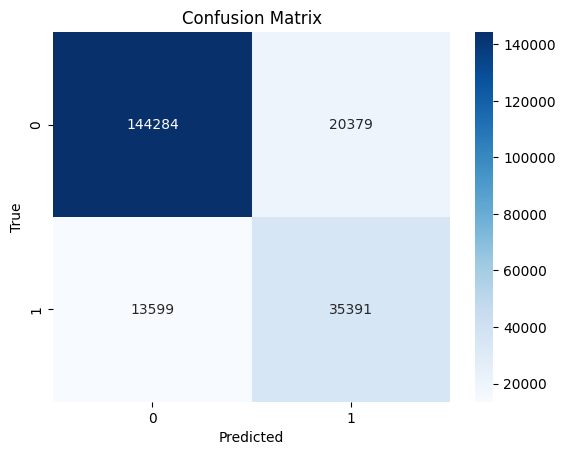

              precision    recall  f1-score   support

           0       0.91      0.88      0.89    164663
           1       0.63      0.72      0.68     48990

    accuracy                           0.84    213653
   macro avg       0.77      0.80      0.79    213653
weighted avg       0.85      0.84      0.84    213653



In [28]:
optimize_and_train(X_train_scaled, y_smenn, X_test_scaled, y_test, use_smoteenn = True)

## Data SMOTE ENN + Feature

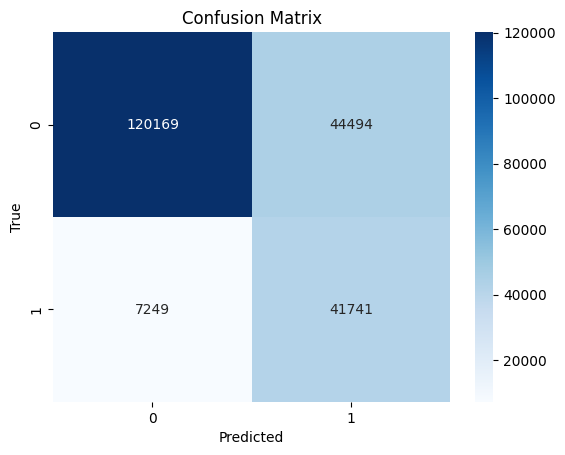

              precision    recall  f1-score   support

           0       0.94      0.73      0.82    164663
           1       0.48      0.85      0.62     48990

    accuracy                           0.76    213653
   macro avg       0.71      0.79      0.72    213653
weighted avg       0.84      0.76      0.78    213653



In [29]:
train_and_evaluate_xgb(X_train_scaled, y_smenn, X_test_scaled, y_test, top_features = top_features)

## Data SMOTE ENN + Feature + Tune

[I 2025-05-05 17:24:43,530] A new study created in memory with name: no-name-d1d75819-a155-41e1-8f79-2702b9804d0d
[I 2025-05-05 17:24:55,981] Trial 0 finished with value: 0.6182185048979725 and parameters: {'n_estimators': 443, 'learning_rate': 0.27094238351733557, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.6538348585741287, 'colsample_bytree': 0.8991504446770361, 'gamma': 3.6231746360852273, 'threshold': 0.45000000000000007}. Best is trial 0 with value: 0.6182185048979725.
[I 2025-05-05 17:25:03,956] Trial 1 finished with value: 0.5212188338971624 and parameters: {'n_estimators': 300, 'learning_rate': 0.283963608189554, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.5674352879391211, 'colsample_bytree': 0.739757806204157, 'gamma': 0.6933076972807733, 'threshold': 0.9}. Best is trial 0 with value: 0.6182185048979725.
[I 2025-05-05 17:25:10,425] Trial 2 finished with value: 0.639527613754776 and parameters: {'n_estimators': 148, 'learning_rate': 0.010235135996057475, '

Best trial:
FrozenTrial(number=43, state=1, values=[0.657937330641788], datetime_start=datetime.datetime(2025, 5, 5, 17, 30, 52, 200857), datetime_complete=datetime.datetime(2025, 5, 5, 17, 30, 56, 28325), params={'n_estimators': 119, 'learning_rate': 0.19596597534696658, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.5762886845524152, 'colsample_bytree': 0.6781295274680574, 'gamma': 4.728542831983612, 'threshold': 0.8}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=5.0, log=False, low=0.0, s

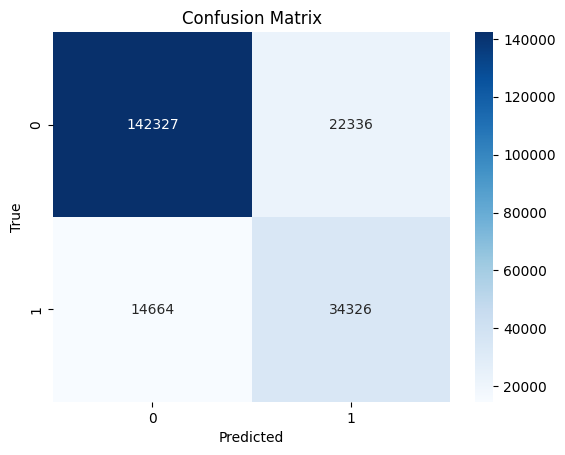

              precision    recall  f1-score   support

           0       0.91      0.86      0.88    164663
           1       0.61      0.70      0.65     48990

    accuracy                           0.83    213653
   macro avg       0.76      0.78      0.77    213653
weighted avg       0.84      0.83      0.83    213653



In [30]:
optimize_and_train(X_train_scaled, y_smenn, X_test_scaled, y_test, top_features=top_features,  use_smoteenn = True)